# Project Title: 
# Identify Health Care Professionals Using Transfer Learning on a Pre-trained Convolutional Neural Network (Resnet18)

Author: Kelvin Tham Kum Hong 

Dated: 25 Feb 2018

## Aim

#### Importing Libraries

In [1]:
# Basics
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import time
import os
import copy
import PIL

# PyTorch
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
plt.ion() # Interactive mode
%matplotlib inline

In [2]:
# Check library versions
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scipy: {}'.format(scipy.__version__))
print('pytorch: {}'.format(torch.__version__))
print('torchvision: {}'.format(torchvision.__version__))

pandas: 0.21.1
numpy: 1.12.1
matplotlib: 2.1.1
seaborn: 0.8.1
scipy: 1.0.0
pytorch: 0.3.0.post4
torchvision: 0.2.0


## Transfer Learning Workflow (PyTorch)

We will do the following steps in order:
1. Loading and normalizing data (image set)
2. Create a general function to train a model
3. Create a generic function to display predictions for a few images

Using ConvNet as fixed feature extractor (achieved 100% accuracy on validation set of 45 images in 22mins): Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

### 1. Analyze and Prepare Data (Image Set)

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([transforms.Resize(224), transforms.RandomCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

data_dir = 'data/HCW'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [4]:
print(dataset_sizes, class_names)
print(image_datasets)

{'train': 437, 'val': 97} ['doctor', 'nurse', 'patient']
{'train': <torchvision.datasets.folder.ImageFolder object at 0x11725c6a0>, 'val': <torchvision.datasets.folder.ImageFolder object at 0x11725c8d0>}


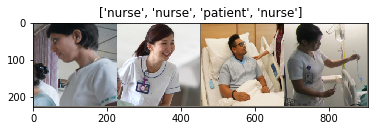

In [5]:
# Show some training images
def imshow(inp, title=None):
    '''Imshow for Tensor'''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid of training data
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2. Generic function to train a model

In [6]:
Epochs = []
Training = []
Validation = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        Epochs.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # Get the inputs
                inputs, labels = data

                # Wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward + Optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
                Training.append(epoch_acc*100)
            else:
                Validation.append(epoch_acc*100)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy and save the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "HCW_wts")
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
# Plot training, validation accuracy graph vs epoch runs
def plot_training(Epochs, Training, Validation):    
    plt.figure(figsize=(12,6))
    plt.plot(Epochs, Training, label='Training')
    plt.plot(Epochs, Validation, label='Validation')
    plt.title("SGD Training and Validation Accuracy, Batch=4, Lr=0.001", fontsize=20)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.ylim(0,100)
    plt.legend(loc='lower right')
    plt.show()

### 3. Generic function to display predictions for a few images

In [8]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        values, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot()
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

In [11]:
# Jeremy's Code
import itertools

predictions = []
label = []
probs = []
merged_probs = []

for i, data in enumerate(dataloaders['val']):
    inputs, labels = data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
        
    outputs = model_conv(inputs)
    # Activation and prediction for each image 
    _, preds = torch.max(outputs.data, 1)
    
    # Extract labels into a list
    labels = labels.data.cpu().numpy()
    label.append(labels)
    merged_labels = list(itertools.chain(*label))
    
    # Extract predictions into a list
    preds = preds.numpy()
    predictions.append(preds)
    merged_preds = list(itertools.chain(*predictions))
    
    # Extract probabilities into a list
    x = torch.nn.functional.softmax(outputs)
    probs = x.data.cpu().numpy()
    for batch in probs:
        merged_probs.append(max(batch))

/Users/kelvintham/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [62]:
# Returns indices of matches between 2 lists
matches = list(i[0] == i[1] for i in zip(merged_labels, merged_preds)); matches[:5]

[True, True, True, True, True]

In [61]:
# Filter values from list
[elem for elem in matches if elem == True][:5]

[True, True, True, True, True]

In [32]:
# Returns indices of 4 random filtered values from list
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask([elem for elem in matches if elem == is_correct])

In [33]:
rand_by_correct(True)

array([11, 42, 41, 48])

In [87]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        ax = f.add_subplot(rows, len(ims)//rows, i+1)
        ax.axis('Off')
        if titles is not None: sx.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

# TODO: How to load image from dataset??
def load_img_id(ds, idx): return np.array(PIL.Image.open(data_dir+'/val'[idx]))

In [88]:
def plot_val_with_title(idxs, title):
    print(title)
    imgs = [load_img_id(image_datasets['val'],x) for x in idxs]
    title_probs = [merged_probs[x] for x in idxs]
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [59]:
imgs = [(image_datasets['val'],x) for x in rand_by_correct(True)]; imgs

[(<torchvision.datasets.folder.ImageFolder at 0x11725c8d0>, 32),
 (<torchvision.datasets.folder.ImageFolder at 0x11725c8d0>, 10),
 (<torchvision.datasets.folder.ImageFolder at 0x11725c8d0>, 33),
 (<torchvision.datasets.folder.ImageFolder at 0x11725c8d0>, 30)]

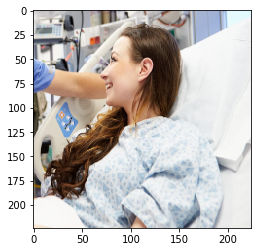

In [85]:
plt.imshow(np.array(PIL.Image.open('P056.jpg')))

In [86]:
data_dir+'/val'

'data/HCW/val'

In [60]:
title_probs = [merged_probs[x] for x in rand_by_correct(True)]; title_probs

[0.97486013, 0.99339789, 0.85221022, 0.97928339]

In [89]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Correctly classified


IndexError: string index out of range

### 4. ConvNet as *fixed feature extractor (Define model, loss function and optimizer) - Only train last layer

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)
model_conv.load_state_dict(torch.load("HCW_wts"))
print(model_conv.fc)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optmized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Linear(in_features=512, out_features=3)


#### 4.1 Train the model

In [9]:
# Train for first 25 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.9053 Acc: 0.5606
val Loss: 0.4271 Acc: 0.8265

Epoch 2/25
----------
train Loss: 0.6764 Acc: 0.7231
val Loss: 0.3374 Acc: 0.8878

Epoch 3/25
----------
train Loss: 0.6723 Acc: 0.7185
val Loss: 0.3807 Acc: 0.8571

Epoch 4/25
----------
train Loss: 0.6227 Acc: 0.7346
val Loss: 0.4589 Acc: 0.8367

Epoch 5/25
----------
train Loss: 0.6121 Acc: 0.7689
val Loss: 0.4345 Acc: 0.8367

Epoch 6/25
----------
train Loss: 0.6073 Acc: 0.7666
val Loss: 0.3313 Acc: 0.8367

Epoch 7/25
----------
train Loss: 0.5968 Acc: 0.7620
val Loss: 0.4134 Acc: 0.8571

Epoch 8/25
----------
train Loss: 0.3841 Acc: 0.8421
val Loss: 0.2868 Acc: 0.8776

Epoch 9/25
----------
train Loss: 0.4890 Acc: 0.8055
val Loss: 0.2878 Acc: 0.8571

Epoch 10/25
----------
train Loss: 0.4367 Acc: 0.8307
val Loss: 0.3146 Acc: 0.8571

Epoch 11/25
----------
train Loss: 0.3667 Acc: 0.8604
val Loss: 0.3420 Acc: 0.8265

Epoch 12/25
----------
train Loss: 0.4226 Acc: 0.8124
val Loss: 0.2869 Acc: 0.8571

E

In [10]:
# Train for first 25 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.9850 Acc: 0.5515
val Loss: 0.5593 Acc: 0.7755

Epoch 2/25
----------
train Loss: 0.6584 Acc: 0.7323
val Loss: 0.3948 Acc: 0.8265

Epoch 3/25
----------
train Loss: 0.5483 Acc: 0.7826
val Loss: 0.4298 Acc: 0.8265

Epoch 4/25
----------
train Loss: 0.6380 Acc: 0.7368
val Loss: 0.4475 Acc: 0.8265

Epoch 5/25
----------
train Loss: 0.5876 Acc: 0.7757
val Loss: 0.6460 Acc: 0.8163

Epoch 6/25
----------
train Loss: 0.6516 Acc: 0.7551
val Loss: 0.2977 Acc: 0.8469

Epoch 7/25
----------
train Loss: 0.4854 Acc: 0.8146
val Loss: 0.6366 Acc: 0.7959

Epoch 8/25
----------
train Loss: 0.4918 Acc: 0.8101
val Loss: 0.2876 Acc: 0.8776

Epoch 9/25
----------
train Loss: 0.3818 Acc: 0.8719
val Loss: 0.2966 Acc: 0.8673

Epoch 10/25
----------
train Loss: 0.4462 Acc: 0.8192
val Loss: 0.3541 Acc: 0.8571

Epoch 11/25
----------
train Loss: 0.4038 Acc: 0.8398
val Loss: 0.2900 Acc: 0.8878

Epoch 12/25
----------
train Loss: 0.3686 Acc: 0.8741
val Loss: 0.3014 Acc: 0.8673

E

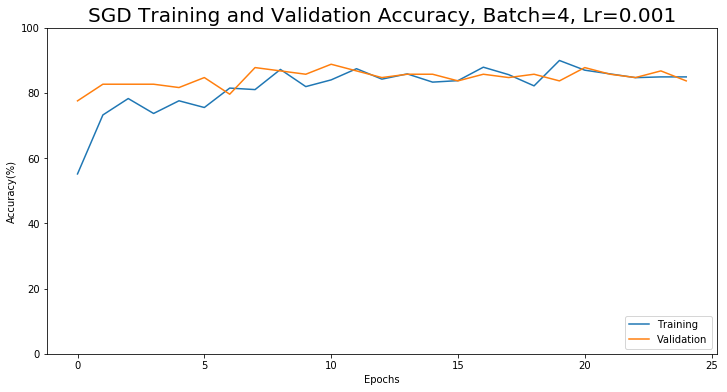

In [13]:
plot_training(Epochs, Training, Validation)

#### 4.2 Visualize Results

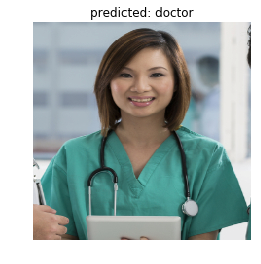

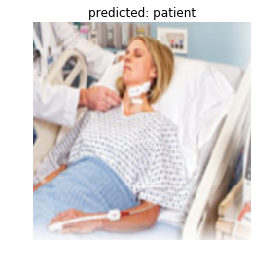

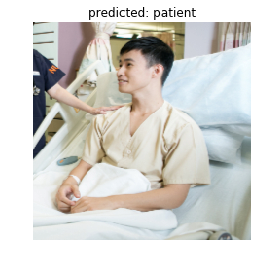

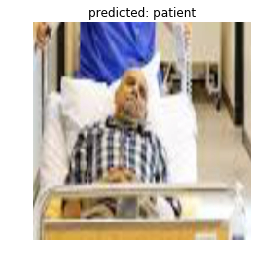

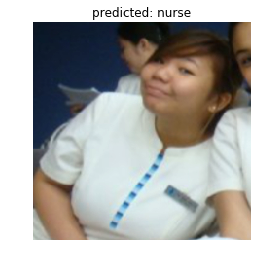

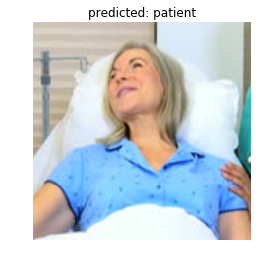

In [21]:
# Test
visualize_model(model_conv)
plt.ioff()
plt.show()

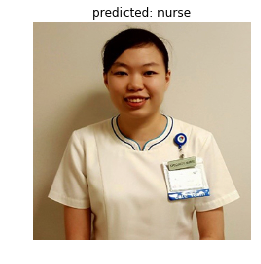

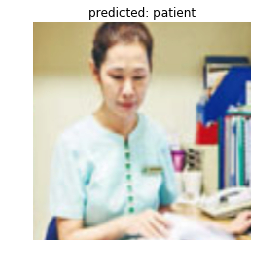

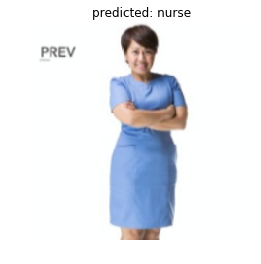

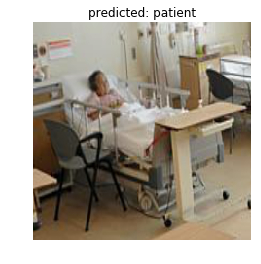

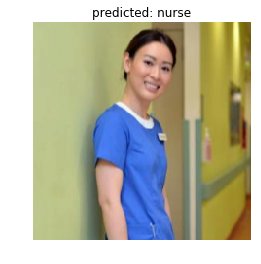

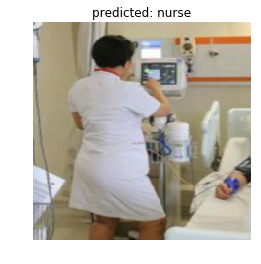

In [9]:
# Test
visualize_model(model_conv)
plt.ioff()
plt.show()